## 02_Preprocessing

**Description:** Loading in subreddit post data, conducting some general Exploratory Data Analysis (EDA), and readying the data for fitting models.

In [1]:
import csv
import json
import pickle
import re

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import stop_words

from nltk.tokenize import RegexpTokenizer

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

**Loading in Reddit Posts**

In [2]:
with open('../data/nto_t.pkl', 'rb') as f:
    nto_t = pickle.load(f)
with open('../data/to_t.pkl', 'rb') as f:
    to_t = pickle.load(f)

**Deleting Duplicates & Merging Titles into single DataFrame**

In [3]:
nto_t.drop_duplicates(inplace=True)
to_t.drop_duplicates(inplace=True)
nto_t.info(), to_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4086 entries, 0 to 4999
Data columns (total 2 columns):
Title    4086 non-null object
sub      4086 non-null int64
dtypes: int64(1), object(1)
memory usage: 95.8+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4720 entries, 0 to 4999
Data columns (total 2 columns):
Title    4720 non-null object
sub      4720 non-null int64
dtypes: int64(1), object(1)
memory usage: 110.6+ KB


(None, None)

In [4]:
nto_t.head()

,Title,sub
0,"Snapchat map mislabeled New York City as ""Jewt...",1
1,Baby Mayor Kahn balloon to fly over Parliament...,1
2,"Love Lorn Dolphin ""Zafar"" Causes French Beach Ban",1
3,Permission denied for PETA to honor dead lobst...,1
4,This guy wanted his head to look like a skull,1


In [5]:
to_t.head()

,Title,sub
0,NASCAR Race Stops To Wait For Family Of Ducks ...,0
1,Evolution Definitively Proven As Scientists Ca...,0
2,Trump Disapproval Rating Reaches All-Time None...,0
3,Trump Teeters On White House Ledge Weighing Pr...,0
4,Eminem Horrified Upon Being Informed That ‘Fag...,0


In [6]:
df = pd.concat([nto_t, to_t], ignore_index=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8806 entries, 0 to 8805
Data columns (total 2 columns):
Title    8806 non-null object
sub      8806 non-null int64
dtypes: int64(1), object(1)
memory usage: 137.7+ KB


In [8]:
df.iloc[4086, ]

Title    NASCAR Race Stops To Wait For Family Of Ducks ...
sub                                                      0
Name: 4086, dtype: object

**Pickling Merged DataFrame - Just in Case**

In [9]:
# with open('../data/df.pkl', 'wb') as f:
#     pickle.dump(df, f)

### EDA

**Getting Rid of References to "The Onion"**

I noticed that when I initially processed this dataset, many headlines contained the word "onion", the majority of which were headlines obtained from "The Onion". In order to better differentiate headlines, without actually relying on the precence of the word "onion", I'm going to delete all posts containing the word.

In [10]:
o_index = df[df['Title'].str.contains('onion|Onion')].index
df.drop(index=o_index, inplace=True)

**Getting Rid of Punctuation**

In [11]:
titles = [re.sub("[^a-zA-Z]"," ",title) for title in df['Title']]

**Preprocessing via NLTK**

In [12]:
tokenizer = RegexpTokenizer(r'\w+')
title_tokens = [tokenizer.tokenize(title.lower()) for title in titles]
df['tokens'] = title_tokens

**Overview of My Dataset**

In [13]:
df['length'] = [len(title) for title in df['Title']]

In [14]:
df.head()

,Title,sub,tokens,length
0,"Snapchat map mislabeled New York City as ""Jewt...",1,"[snapchat, map, mislabeled, new, york, city, a...",54
1,Baby Mayor Kahn balloon to fly over Parliament...,1,"[baby, mayor, kahn, balloon, to, fly, over, pa...",51
2,"Love Lorn Dolphin ""Zafar"" Causes French Beach Ban",1,"[love, lorn, dolphin, zafar, causes, french, b...",49
3,Permission denied for PETA to honor dead lobst...,1,"[permission, denied, for, peta, to, honor, dea...",74
4,This guy wanted his head to look like a skull,1,"[this, guy, wanted, his, head, to, look, like,...",45


In [15]:
df['sub'].value_counts()

0    4605
1    4079
Name: sub, dtype: int64

There's now a smaller difference in total number of posts, since I deleted "Onion" related headlines.

**Combined Dataset Vocabulary**

In [14]:
all_words = []

for title in title_tokens:
    for t in title:
        all_words.append(t)

In [15]:
VOCAB = set(all_words)

**Comparing character length b/w "The Onion" and "Not the Onion" headlines**

In [16]:
df['length'].mean(), df['length'][df['sub'] == 1].mean(), df['length'][df['sub'] == 0].mean()

(80.58164440350069, 72.10198578082863, 88.09272529858849)

**Comparing Token Counts b/w "The Onion" and "Not the Onion" headlines**

In [17]:
df['token_count'] = df['tokens'].apply(lambda x: len(x))

In [18]:
df['token_count'].mean(), df['token_count'][df['sub']== 1].mean(), df['token_count'][df['sub']== 0].mean()

(13.571050207277752, 12.019122333905369, 14.9457111834962)

**Further Analysis**

|**Dataset**|**Avg Character Count**|**Avg Word Count**|
|---|---|---|
|Combined|80.58|13.57|
|Not the Onion|72.10|12.02|
|The Onion|88.09|14.95|

With 8806 headlines, that gives us an average word count of ~13.57 per headline, and an average character count of ~80.58. 

Breaking the datasets apart, we can see that there's quite a bit of difference between the average word & character counts of "Not the Onion" and "The Onion" headlines.

**General Word Counts For Each Dataset**

In [27]:
# Last "Not the Onion" Headline
df.iloc[4078]

Title          English football team pick a literal boiler as...
sub                                                            1
tokens         [english, football, team, pick, a, literal, bo...
length                                                        60
token_count                                                   10
Name: 4085, dtype: object

In [28]:
title_tokens[4078]

['english',
 'football',
 'team',
 'pick',
 'a',
 'literal',
 'boiler',
 'as',
 'their',
 'mascot']

In [29]:
the_onion = []
not_the_onion = []

for title in title_tokens[:4079]:
    for word in title:
        not_the_onion.append(word)

for title in title_tokens[4079:]:
    for word in title:
        the_onion.append(word)

In [32]:
print("My dataset consists of {} words, and a unique vocabulary of {} words".format(len(all_words), len(VOCAB)))
print("The 'Not the Onion' dataset consists of {} words, and a unique vocab of {} words".format(len(not_the_onion), 
                                                                                                len(set(not_the_onion))))
print("The 'The Onion' dataset consists of {} words, and a unique vocab of {} words".format(len(the_onion), 
                                                                                                len(set(the_onion))))

My dataset consists of 117851 words, and a unique vocabulary of 15015 words
The 'Not the Onion' dataset consists of 49026 words, and a unique vocab of 8389 words
The 'The Onion' dataset consists of 68825 words, and a unique vocab of 11474 words


**Examining General Word Counts**

**Word Counts - Combined Dataset**

In [37]:
cv_s = CountVectorizer(stop_words='english')

word_vector_stop = cv_s.fit_transform(all_words)

word_df_s = pd.DataFrame(word_vector_stop.toarray(), columns=cv_s.get_feature_names())
word_counts_stop = word_df_s.sum(axis=0)

In [38]:
wc = word_counts_stop.sort_values(ascending=False).head(25)
wc

man          635
trump        600
new          462
life         416
say          391
news         359
just         315
woman        305
says         266
police       243
said         219
people       218
year         214
old          202
video        185
like         172
white        170
report       163
day          150
time         150
sex          148
house        148
questions    143
years        143
know         139
dtype: int64

In [29]:
index_list = list(wc.index)

In [30]:
wc_df = pd.concat([wc, pd.Series(index_list, index=wc.index)], axis=1)
wc_df.rename({0:'Count', 1:'Term'}, axis=1, inplace=True)

**Word Counts - Not the Onion vs The Onion**

In [33]:
cv_nto = CountVectorizer(stop_words='english')
cv_to = CountVectorizer(stop_words='english')

wv_nto = cv_nto.fit_transform(not_the_onion)
wv_to = cv_to.fit_transform(the_onion)

wv_df_nto = pd.DataFrame(wv_nto.toarray(), columns=cv_nto.get_feature_names())
wv_df_to = pd.DataFrame(wv_to.toarray(), columns=cv_to.get_feature_names())

In [34]:
wc_nto = wv_df_nto.sum(axis=0)
wc_to = wv_df_to.sum(axis=0)

In [35]:
t25_nto = wc_nto.sort_values(ascending=False).head(25)
t25_to = wc_to.sort_values(ascending=False).head(25)

In [36]:
t25_nto

man         390
trump       312
police      217
says        204
woman       200
new         159
say         123
people      114
sex         103
old         101
year        101
years        80
white        77
accused      73
arrested     73
men          72
florida      70
house        66
home         66
like         64
donald       64
claims       64
women        64
gets         63
black        62
dtype: int64

In [37]:
t25_to

life         395
new          296
news         292
trump        285
say          267
just         253
man          243
said         195
video        140
questions    138
know         127
day          122
report       116
time         116
year         112
like         107
woman        105
people       102
old          101
white         91
week          90
need          88
house         82
nation        82
way           81
dtype: int64

**Visualizing Word Counts - Combined Dataset**

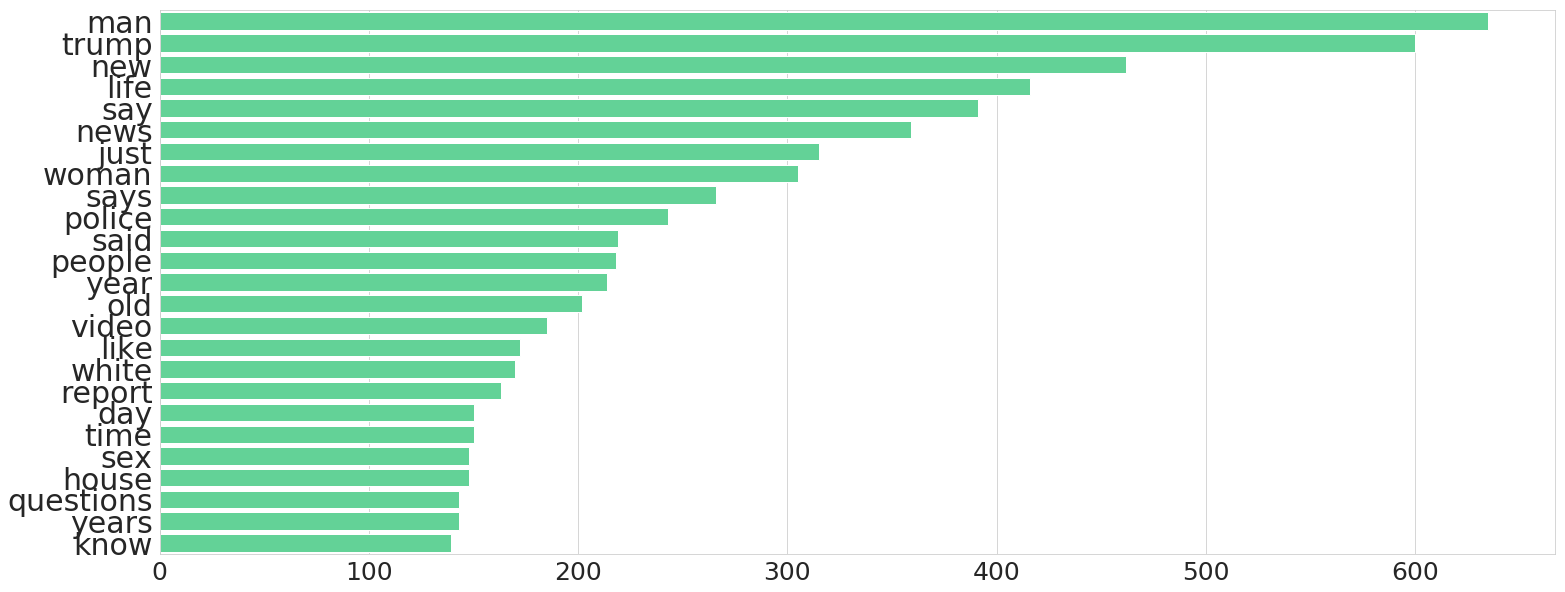

In [38]:
sns.set_style("whitegrid")
plt.figure(figsize=(25,10))
plt.xticks(fontsize=25)
plt.yticks(fontsize=30)
sns.barplot(data=wc_df, x='Count', y='Term', orient='h', color='#63d297', saturation=1)
plt.xlabel('')
plt.ylabel('')
# plt.savefig('../images/top_terms.png')

This listing feels like what you'd see in a 'most popular news stories feature these words' list. That is, what you'd see with the inclusion of terms like "trump", "police", and "sex" (i.e., subjects that may be polarizing). Beyond those words, we see common english nouns like 'man', 'woman', 'video', 'people', etc. What's most surprising about this list is the inclusion of "news". I'm curious to know what the most common contextual uses for that word in these headlines are.

**Visualzing Word Counts - Not the Onion vs The Onion**

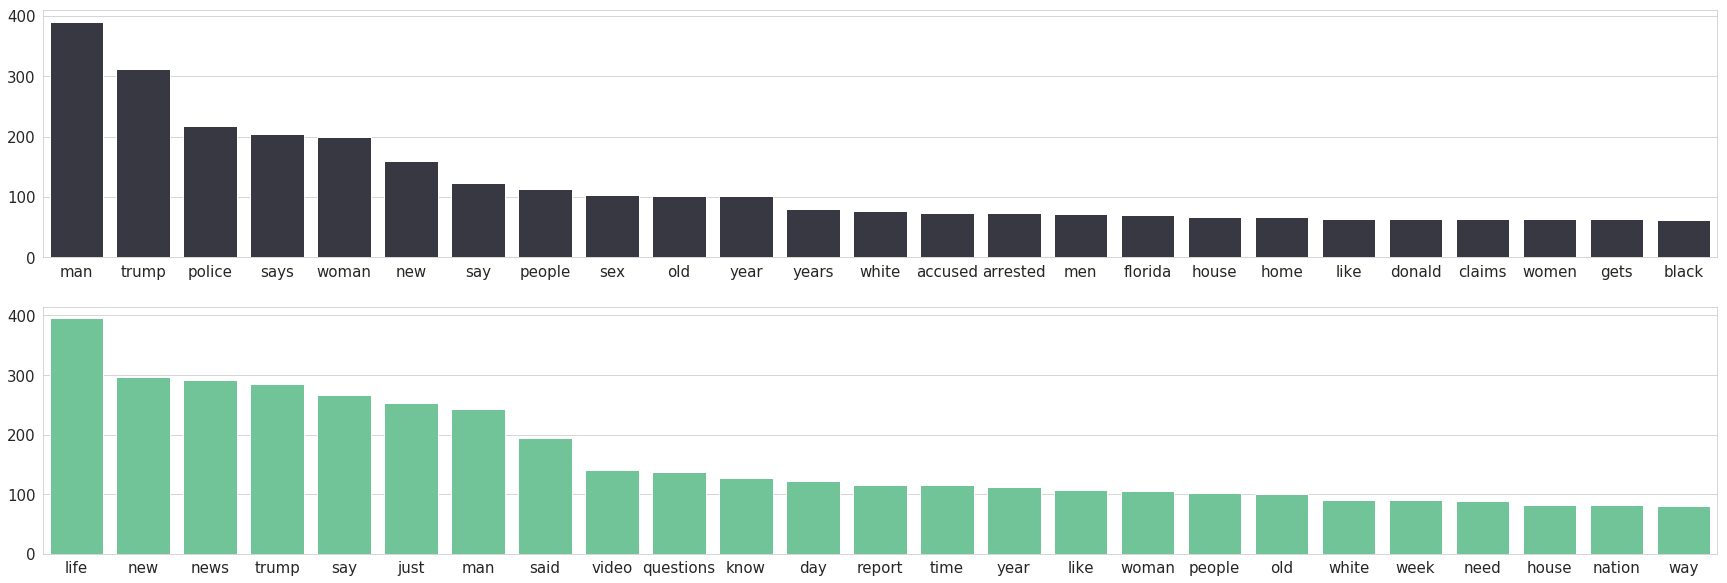

In [55]:
fig, (ax1, ax2)= plt.subplots(nrows=2, ncols=1, figsize=(30, 10))
sns.set_style('whitegrid')
ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

sns.barplot(y=t25_nto, x=t25_nto.index, color="#353744", ax=ax1, orient='v')

sns.barplot(y=t25_to, x=t25_to.index, color="#63d297", ax=ax2, orient='v')

**Creating Target Variable**

In [63]:
target = df['sub']

### Initializing Vectorizer

I plan on creating two vectorizers that will actually be run into my model. One featuring an `ngram_range` of (1,1), and another with a range of (1,2), to see if incorporating any phrasing assists in the accuracy of my model. Given the size of each post I'm looking at (~13.55 words), I wouldn't *assume* that there would be much to clean from an increased range, though I don't think it'll hurt to try.

**New Stuff**

In [2]:
tfidf = TfidfVectorizer(stop_words='english', min_df=.01, max_df=1.0, ngram_range=(1,3))
# term_mat = tfidf.fit_transform(df['Title'])

In [18]:
term_df = pd.SparseDataFrame(term_mat, columns=tfidf.get_feature_names())
term_df.fillna(0, inplace=True)

In [19]:
term_df.head()

,000,american,black,car,child,day,donald,donald trump,facebook,gets,...,trump,video,way,white,woman,women,world,year,year old,years
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Old Stuff**

In [29]:
tfidf = TfidfVectorizer(stop_words='english', min_df=5, max_df=1.0)
tfidf_2 = TfidfVectorizer(stop_words='english', min_df=5, max_df=1.0, ngram_range=(1, 2))

A minimum document frequency of 5 seems like a good starting point. I'll consider coming back and re-Vectorizing if my model scores are unsatisfactory.

In [30]:
term_mat = tfidf.fit_transform(df['Title'])
term_mat_2 = tfidf_2.fit_transform(df['Title'])

In [31]:
len(tfidf.get_feature_names()), len(tfidf_2.get_feature_names())

(3488, 4168)

Both of these numbers seem like an awful lot of features given the size of my dataset. While I still plan on modeling based off of the full datasets, I'll toss my smallest matrix through SVD to retreive the most important values. I believe this will lead to more accurate predictions.

**Tossing Vectorizers into DataFrame**

In [32]:
term_df = pd.SparseDataFrame(term_mat, columns=tfidf.get_feature_names())
term_df_2 = pd.SparseDataFrame(term_mat_2, columns=tfidf_2.get_feature_names())

In [33]:
term_df.fillna(0, inplace=True)
term_df_2.fillna(0, inplace=True)

### Initialize SVD

**New**

In [22]:
# tfidf (min_df = .01, ngram = 1,3)
# SVD = TruncatedSVD(n_components=1000)
# svd_matrix = SVD.fit_transform(term_df)
# svd_matrix.shape

**Old**

In [34]:
SVD = TruncatedSVD(n_components=1000)
svd_matrix = SVD.fit_transform(term_df)
svd_matrix.shape

(8806, 1000)

In [35]:
SVD.explained_variance_ratio_.sum()

0.6692499038411953

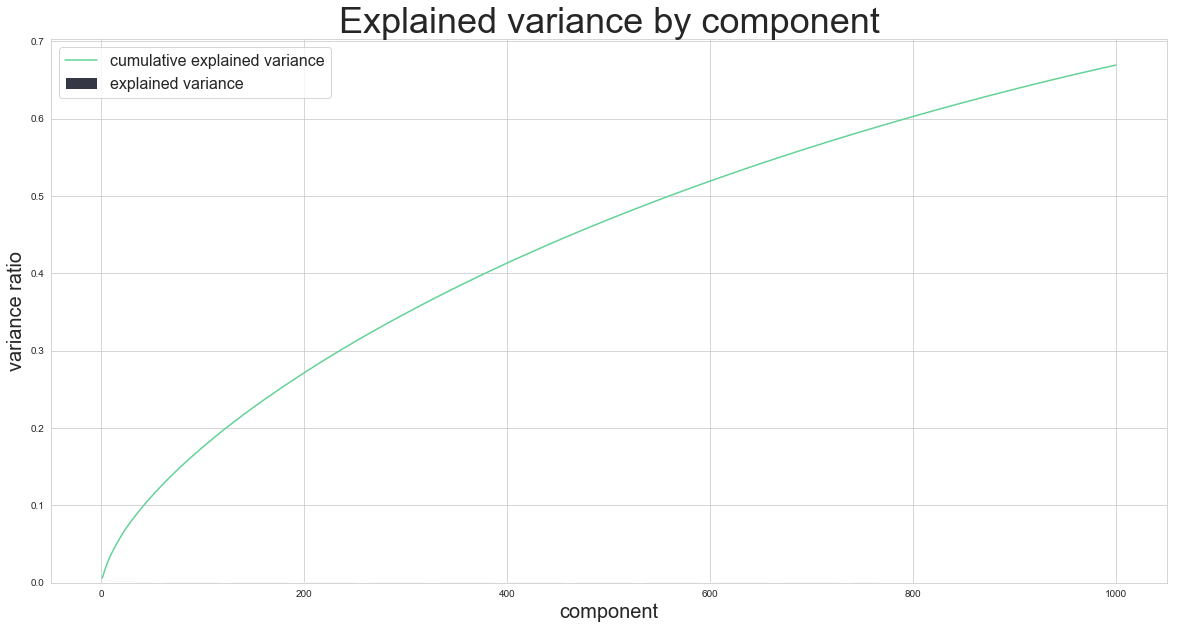

In [36]:
fig = plt.figure(figsize=(20,10))
plt.bar(np.array(range(1000))+1, 
        SVD.explained_variance_ratio_, 
        color='#353744', 
        label='explained variance')
plt.plot(np.array(range(1000))+1, 
         np.cumsum(SVD.explained_variance_ratio_), 
         label='cumulative explained variance',
         color='#63d297')
plt.legend(fontsize=16)
plt.xlabel('component', fontsize=20)
plt.ylabel('variance ratio', fontsize=20)
plt.title('Explained variance by component', fontsize=36);

It seems as though every feature explains a minute amount of variance within the entire dataset. Given the similarity with which The Onion and non-Onion (yet still quite crazy sounding) headlines happen to have, this isn't entirely surprising, though I didn't expect that not a single component would explain even 3% of the variance. I can't even visualize a single components variance on this plot.

In [37]:
component_names = ["component_"+str(i+1) for i in range(1000)]
svd_df = pd.DataFrame(svd_matrix, columns=component_names)

In [38]:
svd_df.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_991,component_992,component_993,component_994,component_995,component_996,component_997,component_998,component_999,component_1000
0,0.017320,0.081088,-0.033523,0.121732,0.229534,-0.055085,0.197615,0.060283,0.064098,-0.029800,...,0.007577,0.000361,0.001633,0.009625,-0.000631,-0.002298,0.000496,-0.005112,0.003521,-0.002469
1,0.005344,0.018737,-0.006767,-0.008445,-0.006199,-0.000997,0.002856,0.010173,-0.000499,0.001820,...,0.008311,0.044279,-0.010798,0.005571,-0.007058,-0.030551,-0.030914,0.017937,0.022839,0.035893
2,0.005228,0.020008,-0.006038,0.007440,0.003707,-0.001170,-0.007097,0.003213,-0.012215,0.002708,...,0.008681,-0.010644,-0.012131,0.006742,0.006108,0.006144,0.010917,-0.032139,-0.032518,-0.029128
3,0.006595,0.024682,-0.009843,0.002697,-0.000422,-0.000586,-0.003821,-0.006777,-0.013209,-0.000255,...,0.009840,0.004444,-0.019821,0.003449,0.012134,-0.014290,-0.010587,-0.010856,-0.006851,0.002863
4,0.018271,0.071394,-0.015829,0.013938,0.018760,0.001742,-0.034628,-0.030071,-0.060521,-0.023220,...,0.002206,-0.001233,-0.006522,-0.001451,0.004837,0.019210,-0.014802,-0.005918,0.008490,-0.012990


I'm going to examine the difference between the TFIDF and SVD matrices. I want to get a good idea of which dataset may work best for modeling, and if there's anything that I can clean from the shape of the data.

## Examining TFIDF & SVD Weights

In [111]:
term_weight_sums = term_df.apply(lambda x: sum(x), 1)
term_weight_sums_2 = term_df_2.apply(lambda x: sum(x), 1)
mean_tws_nto = term_weight_sums[:4085].mean()
mean_tws_to = term_weight_sums[4086:].mean()
std_tws_nto = np.std(term_weight_sums[:4085]) 
std_tws_to = np.std(term_weight_sums[4086:])

mean_tws2_nto = term_weight_sums_2[:4085].mean()
mean_tws2_to = term_weight_sums_2[4086:].mean()
std_tws2_nto = np.std(term_weight_sums_2[:4085])
std_tws2_to = np.std(term_weight_sums_2[4086:])

sparse_df = term_df.apply(lambda x: x == 0.0)
sparse_totals = sparse_df.apply(lambda x: sum(x), 1)
mean_sparse_total_nto = sparse_totals[:4085].mean()
mean_sparse_total_to = sparse_totals[4086:].mean()

sparse_df2 = term_df_2.apply(lambda x: x == 0.0)
sparse_totals2 = sparse_df2.apply(lambda x: sum(x), 1)
mean_sparse_totals2_nto = sparse_totals[:4085].mean()
mean_sparse_totals2_to = sparse_totals[4086:].mean()

svd_weight_sums = svd_df.apply(lambda x: sum(x), 1)
svd_weight_sums_abs = svd_weight_sums.apply(lambda x: np.abs(x),1)
mean_weight_svd_nto = svd_weight_sums_abs[:4085].mean()
mean_weight_svd_to = svd_weight_sums_abs[4086:].mean()

std_weight_svd_nto = np.std(svd_weight_sums_abs[:4085])
std_weight_svd_to = np.std(svd_weight_sums_abs[4086:])

sparse_svd_df = svd_df.apply(lambda x: x == 0.0)
sparse_svd_totals = sparse_svd_df.apply(lambda x: sum(x), 1)
mean_sparse_svd_total_nto = sparse_svd_totals[:4085].mean()
mean_sparse_svd_total_to = sparse_svd_totals[4086:].mean()

In [115]:
print('''
    - Mean Total Term Weight - Not the Onion: {:.3f}
    - Mean Total Term Weight - The Onion: {:.3f}
    - Mean Total Term Weight - TFIDF II - Not the Onion: {:.3f}
    - Mean Total Term Weight - TFIDF II - The Onion: {:.3f}    
    - Mean Total Term Weight - SVD - Not the Onion: {:3f}
    - Mean Total Term Weight - SVD - The Onion: {:3f}
   
    - Standard Deviation of Total Term Weights - Not the Onion: {:.3f}
    - Standard Deviation of Total Term Weights - The Onion: {:.3f}
    - Standard Deviation of Total Term Weights - TFIDF II - Not the Onion: {:.3f}
    - Standard Deviation of Total Term Weights - TFIDF II - The Onion: {:.3f}
    - Standard Deviation of Total Term Weights - SVD - Not the Onion: {:.3f}
    - Standard Deviation of Total Term Weights - SVD - The Onion: {:.3f}
         
    - Mean Sparse Total - Not the Onion: {:.3f}
    - Mean Sparse Total - The Onion: {:.3f}
    - Mean Sparse Total - TFIDF II - Not the Onion: {:.3f}
    - Mean Sparse Total - TFIDF II - The Onion: {:.3f}
    - Mean Sparse Total - SVD - Not the Onion: {:.3f}
    - Mean Sparse Total - SVD - The Onion: {:.3f}    
         '''.format(mean_tws_nto, mean_tws_to, mean_tws2_nto, mean_tws2_to, mean_weight_svd_nto, mean_weight_svd_to,
                    std_tws_nto, std_tws_to, std_tws2_nto, std_tws2_to, std_weight_svd_nto, std_weight_svd_to,
                    mean_sparse_total_nto, mean_sparse_total_to, mean_sparse_totals2_nto, mean_sparse_totals2_to, mean_sparse_svd_total_nto, mean_sparse_svd_total_to))


    - Mean Total Term Weight - Not the Onion: 2.421
    - Mean Total Term Weight - The Onion: 2.418
    - Mean Total Term Weight - TFIDF II - Not the Onion: 2.567
    - Mean Total Term Weight - TFIDF II - The Onion: 2.509    
    - Mean Total Term Weight - SVD - Not the Onion: 0.666540
    - Mean Total Term Weight - SVD - The Onion: 0.637790
   
    - Standard Deviation of Total Term Weights - Not the Onion: 0.544
    - Standard Deviation of Total Term Weights - The Onion: 0.620
    - Standard Deviation of Total Term Weights - TFIDF II - Not the Onion: 0.661
    - Standard Deviation of Total Term Weights - TFIDF II - The Onion: 0.662
    - Standard Deviation of Total Term Weights - SVD - Not the Onion: 0.501
    - Standard Deviation of Total Term Weights - SVD - The Onion: 0.484
         
    - Mean Sparse Total - Not the Onion: 3481.660
    - Mean Sparse Total - The Onion: 3481.563
    - Mean Sparse Total - TFIDF II - Not the Onion: 3481.660
    - Mean Sparse Total - TFIDF II - The O

**Mean Total Term Weight & Standard Deviation:** My thought here is that a significant enough difference in total weights between The Onion and Not the Onion headlines would make much it easier for my model to differentiate the two classes. It looks like both the SVD and TFIDF with 2-ngram vectors are the most separated. Perhaps that means models using those datasets will be the most accurate, or at least the chances are.

**Mean Sparse Total:** I'm referring to the mean number of 0's present in a given term. My thought here is that since The Onion headlines are slightly longer on average, that they'll end up being less sparse, and therefore easier to dileneate from Not the Onion headlines. This does seem to be the case with the non-SVD matrices, with Not the Onion headlines tending to be more sparse. However, it's the opposite of what I'm seeing with the SVD matrix. It makes me think that there are more telling terms within Not the Onion headlines, i.e., they have include more terms which have a weight.

Going forward, I'll just examine the SVD Matrix with a feature loadings matrix, since I'm seeing a lot of evidence that it'll perform the best in modeling.

## Creating Feature Loadings Matrix 

In [46]:
loadings = pd.DataFrame(SVD.components_,
                        index=component_names,
                        columns=term_df.columns).T

In [40]:
loadings['abs_component_1'] = np.abs(loadings.component_1)
loadings['abs_component_2'] = np.abs(loadings.component_2)

In [41]:
loadings.tail()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_993,component_994,component_995,component_996,component_997,component_998,component_999,component_1000,abs_component_1,abs_component_2
zinke,0.000322,0.001060,0.000397,0.000070,0.000200,-0.000113,-0.000215,0.000286,-0.000819,-0.000164,...,-0.015885,-0.001255,-0.005510,0.014632,-0.018605,-0.004038,-0.007874,0.000635,0.000322,0.001060
zone,0.001770,0.003020,-0.003010,-0.001675,-0.000783,0.003121,0.000812,-0.001065,-0.002768,0.001305,...,0.000609,0.023463,-0.004666,-0.004301,0.004071,0.000003,0.006348,0.006407,0.001770,0.003020
zones,0.000833,0.005813,0.007466,-0.000790,-0.001503,-0.000006,0.000150,-0.002050,0.000225,0.000473,...,-0.004739,0.002158,0.009211,-0.006178,-0.015992,-0.007420,-0.004394,-0.001355,0.000833,0.005813
zoo,0.003133,0.015110,-0.014347,-0.006081,-0.004274,-0.000717,0.004769,-0.008825,-0.004532,-0.004415,...,0.003177,0.016061,-0.024768,-0.008036,-0.002413,0.001732,-0.001544,0.009477,0.003133,0.015110
zuckerberg,0.008379,0.004679,-0.001334,0.004667,0.004102,0.000294,-0.007591,-0.005425,-0.010198,0.023855,...,0.010996,-0.002966,-0.001445,0.017086,-0.005086,0.009352,0.005868,-0.000051,0.008379,0.004679


**Looking at Individual Components**

In [42]:
loadings.sort_values('abs_component_1',ascending=False).head(20)[['component_1']]

,component_1
say,0.694569
said,0.644676
man,0.101917
trump,0.073660
police,0.070640
david,0.067068
james,0.065816
just,0.045089
new,0.043757
john,0.041873


In looking at the first component, it would seem as though lemmatizing (or at least stemming), could assist in consolidating some well-used vocabulary. Nonetheless, I don't plan on going back and lemmatizing unless my model performs poorly.

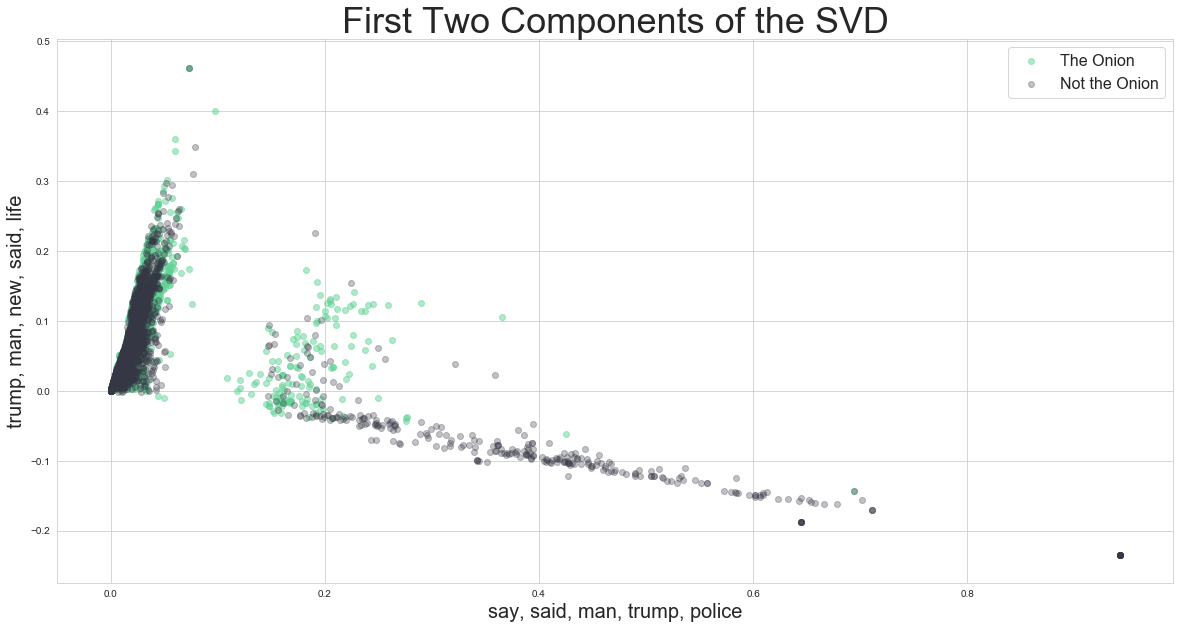

In [43]:
plt.figure(figsize=(20,10))
plt.scatter(svd_df.component_1[target==1], svd_df.component_2[target==1], c='#63d297', alpha=.5)
plt.scatter(svd_df.component_1[target==0], svd_df.component_2[target==0], c='#353744', alpha=.3)
plt.xlabel(f"{', '.join(loadings.sort_values('abs_component_1',ascending=False).head(5)[['component_1']].index)}",
          fontsize=20)
plt.ylabel(f"{', '.join(loadings.sort_values('abs_component_2',ascending=False).head(5)[['component_2']].index)}",
          fontsize=20)
plt.title('First Two Components of the SVD', fontsize=36)
plt.legend(['The Onion', 'Not the Onion'], fontsize=16)

Looking at the orthogonal relationship between the first two components of my SVD, I'm not super confident that my model will be able to accurately (90%+) delineate between Onion and Not the Onion headlines. If the first two components, which explain more of the variance within the dataset than any other two compontets, are largely similar for a majority of values within my datset, it wouldn't seem like they would lend well to making accurate predictions. Nonetheless, there still seems to be a difference in *sparseness* that isn't captured in this plot, so I'm confident I'll arrive at a reasonably accurate model.

**Pickling components of my Dataset for Modeling**

In [23]:
with open('../pickle/term_df_mindf1.pkl', 'wb') as f:
    pickle.dump(term_df, f)

In [65]:
with open('../pickle/term_df_n3.pkl', 'wb') as f:
    pickle.dump(term_df, f)
with open('../pickle/target_r.pkl', 'wb') as f:
    pickle.dump(target, f)

In [44]:
with open('../pickle/tfidf_2.pkl', 'wb') as f:
    pickle.dump(tfidf_2, f)
with open('../pickle/term_df.pkl', 'wb') as f:
    pickle.dump(term_df, f)
with open('../pickle/term_df_2.pkl', 'wb') as f:
    pickle.dump(term_df_2, f)
with open('../pickle/svd_df.pkl', 'wb') as f:
    pickle.dump(svd_df, f)
with open('../pickle/target.pkl', 'wb') as f:
    pickle.dump(target, f)

**Pickling "Final" TFIDF (ngram 1,3)**

In [ ]:
with open('../pickle/')

**Go To: 03_modeling**